In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import joblib

import Models
from AuxiliarFunctions import *

# Carga de Dados

In [2]:
config_file_path = 'data/config.csv'
df_config = pd.read_csv(config_file_path)
train_id = 0

model_type = 'SVM'

In [3]:
df_config

,hash_id,label,raw_files_path,processed_file_folder,processed_file_path,cv_alg,cv_folds,cv_path,preproc_alg,pipeline_path,scaler_alg,train_data_path,train_trgt_path,model_path
0,8738077379487366216,Toy Data Classification with 10 StratifiedKFolds,data/raw,data,data/8738077379487366216_processed_data.csv,StratifiedKFolds,10,data/indexes,Não implementado para a aplicação!!!,data/pipelines,StandardScaler,data/8738077379487366216_train_data.csv,data/8738077379487366216_trgt_data.csv,data/models


In [4]:
df_data = pd.read_csv(df_config['train_data_path'][train_id])
df_trgt = pd.read_csv(df_config['train_trgt_path'][train_id])

In [5]:
model_path = df_config['model_path'][train_id]
df_choose_hyperparameters = pd.read_csv(os.path.join(model_path,'%s_%s_choose_hyperparameters.csv'%(df_config['hash_id'][train_id], model_type)))

In [6]:
print('Choose hyperparams - kernel %s and regularization %s'%(df_choose_hyperparameters['kernel'].values[0],
                                                              df_choose_hyperparameters['regularization'].values[0]))

Choose hyperparams - kernel rbf and regularization 0.9


# Figuras de Mérito de Classificação

In [7]:
train_record = pd.read_csv(os.path.join(model_path,'%s_%s_train_record.csv'%(df_config['hash_id'][train_id], model_type)))
selected_train = train_record[(train_record['kernel']==df_choose_hyperparameters['kernel'].values[0]) & 
                              (train_record['regularization']==df_choose_hyperparameters['regularization'].values[0])]

In [8]:
train_record = pd.read_csv(os.path.join(model_path,'%s_%s_train_record.csv'%(df_config['hash_id'][train_id], model_type)))

mean_grouped = selected_train[['kernel','regularization',
                        'Acc','Sens','Spec','SP', 'AUC', 'Time']].groupby(['kernel', 'regularization']).mean()
std_grouped = selected_train[['kernel','regularization',
                        'Acc','Sens','Spec','SP', 'AUC', 'Time']].groupby(['kernel', 'regularization']).std()
grouped = pd.concat([mean_grouped,std_grouped],axis=0)

grouped

Acc      Sens      Spec        SP       AUC  \
kernel regularization                                                     
rbf    0.9             0.959200  0.959225  0.959176  0.920095  0.959200   
       0.9             0.006512  0.006190  0.009056  0.012482  0.006512   

                           Time  
kernel regularization            
rbf    0.9             1.380122  
       0.9             0.120954

# Matriz de Confusão

Processing SVM Analysis
Processing Analysis for rbf kernel
Processing Analysis for 0.9 regularization
Analysing 1 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/8738077379487366216_SVM_0_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 2 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/8738077379487366216_SVM_1_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 3 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/8738077379487366216_SVM_2_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 4 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/8738077379487366216_SVM_3_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 5 fold of 10 folds

Reading Cross-validation ind

Text(0.5, 1.0, 'Classification for training set')

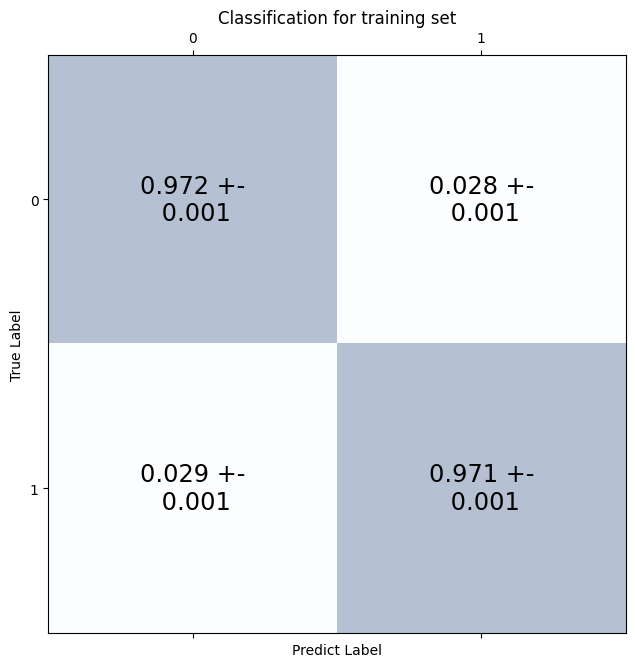

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time

import copy

model_type = 'SVM'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

print('Processing SVM Analysis')

kernels = [df_choose_hyperparameters['kernel'].values[0]]
regularizations = [df_choose_hyperparameters['regularization'].values[0]]


conf_mat = np.zeros((2,2,n_folds))

for kernel in kernels:
    print('Processing Analysis for %s kernel'%(kernel))
    for regularization in regularizations:
        print('Processing Analysis for %s regularization'%(regularization))
        for ifold in range(n_folds):
            #if ifold >= 2: # para desenvolvimento
            #    break
            print('Analysing %i fold of %i folds\n'%(ifold+1, n_folds))
            print('Reading Cross-validation indexes')

            cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            print('Done')
            print('Reading Pipeline Object')
            with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
                [trn_idx,val_idx] = pickle.load(file_handler)

            pipe_name ='%s_%s_CV_fold_%i_of_%i_pipe.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
                pipe = joblib.load(file_handler)

            print('Done')

            trn_data = pipe.transform(df_data)
            trn_trgt = df_trgt.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))

            print('Loading for model')
            model_name = '%s_%s_%i_fold_model_%s_kernel_%s_regularization.pkl'%(df_config['hash_id'][train_id],
                                                                                model_type, ifold, kernel, 
                                                                                str(regularization).replace('.','-'))
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Model is in %s'%(os.path.join(model_path, model_name)))
                prediction_name = copy.copy(model_name)
                prediction_name = prediction_name.replace('.pkl','_prediction_file.csv')
                df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
                (tn, fp, fn, tp) = Models.get_confusion_matrix(df_predict.loc[trn_idx,'target'],
                                                               df_predict.loc[trn_idx,'model_output'])
                #print((tn, fp, fn, tp))
                conf_mat[0,0,ifold] = tn
                conf_mat[0,1,ifold] = fp
                conf_mat[1,0,ifold] = fn
                conf_mat[1,1,ifold] = tp
            else:
                print('No Model \n')

# ============================================== #
#                      Drawing                   #
# ============================================== #
fig, ax = plt.subplots(figsize=(7.5, 7.5))
conf_matrix_mean = np.mean(conf_mat,axis=2)
conf_matrix_std = np.std(conf_mat,axis=2)

ax.matshow(conf_matrix_mean, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix_mean.shape[0]):
    for j in range(conf_matrix_mean.shape[1]):
        text = '%1.3f +-\n %1.3f'%(conf_matrix_mean[i, j],conf_matrix_std[i, j])
        ax.text(x=j, y=i,s=text, va='center', ha='center', size='xx-large')
ax.set_xlabel('Predict Label')
ax.set_ylabel('True Label')
ax.set_xticks([0,1])
ax.set_title('Classification for training set')

Processing SVM Analysis
Processing Analysis for rbf kernel
Processing Analysis for 0.9 regularization
Analysing 1 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/371198118147330886_SVM_0_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 2 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/371198118147330886_SVM_1_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 3 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/371198118147330886_SVM_2_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 4 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/371198118147330886_SVM_3_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 5 fold of 10 folds

Reading Cross-validation indexes

Text(0.5, 1.0, 'Classification for validation set')

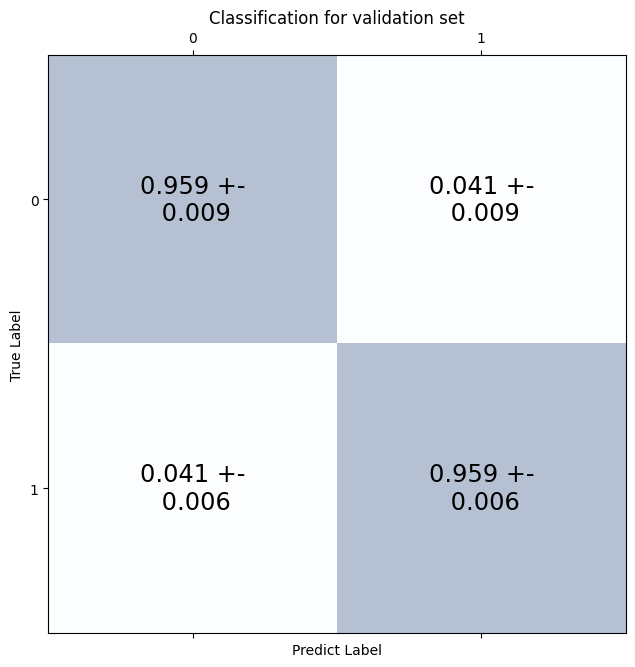

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time

import copy

model_type = 'SVM'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

print('Processing SVM Analysis')

kernels = [df_choose_hyperparameters['kernel'].values[0]]
regularizations = [df_choose_hyperparameters['regularization'].values[0]]


conf_mat = np.zeros((2,2,n_folds))

for kernel in kernels:
    print('Processing Analysis for %s kernel'%(kernel))
    for regularization in regularizations:
        print('Processing Analysis for %s regularization'%(regularization))
        for ifold in range(n_folds):
            #if ifold >= 2: # para desenvolvimento
            #    break
            print('Analysing %i fold of %i folds\n'%(ifold+1, n_folds))
            print('Reading Cross-validation indexes')

            cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            print('Done')
            print('Reading Pipeline Object')
            with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
                [trn_idx,val_idx] = pickle.load(file_handler)

            pipe_name ='%s_%s_CV_fold_%i_of_%i_pipe.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
                pipe = joblib.load(file_handler)

            print('Done')

            trn_data = pipe.transform(df_data)
            trn_trgt = df_trgt.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))

            print('Loading for model')
            model_name = '%s_%s_%i_fold_model_%s_kernel_%s_regularization.pkl'%(df_config['hash_id'][train_id],
                                                                                model_type, ifold, kernel, 
                                                                                str(regularization).replace('.','-'))
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Model is in %s'%(os.path.join(model_path, model_name)))
                prediction_name = copy.copy(model_name)
                prediction_name = prediction_name.replace('.pkl','_prediction_file.csv')
                df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
                (tn, fp, fn, tp) = Models.get_confusion_matrix(df_predict.loc[val_idx,'target'],
                                                               df_predict.loc[val_idx,'model_output'])
                #print((tn, fp, fn, tp))
                conf_mat[0,0,ifold] = tn
                conf_mat[0,1,ifold] = fp
                conf_mat[1,0,ifold] = fn
                conf_mat[1,1,ifold] = tp
            else:
                print('No Model \n')

# ============================================== #
#                      Drawing                   #
# ============================================== #
fig, ax = plt.subplots(figsize=(7.5, 7.5))
conf_matrix_mean = np.mean(conf_mat,axis=2)
conf_matrix_std = np.std(conf_mat,axis=2)

ax.matshow(conf_matrix_mean, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix_mean.shape[0]):
    for j in range(conf_matrix_mean.shape[1]):
        text = '%1.3f +-\n %1.3f'%(conf_matrix_mean[i, j],conf_matrix_std[i, j])
        ax.text(x=j, y=i,s=text, va='center', ha='center', size='xx-large')
ax.set_xlabel('Predict Label')
ax.set_ylabel('True Label')
ax.set_xticks([0,1])
ax.set_title('Classification for validation set')

# Análise de Relevância

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time

import copy

model_type = 'SVM'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

print('Processing SVM Analysis')

kernels = [df_choose_hyperparameters['kernel'].values[0]]
regularizations = [df_choose_hyperparameters['regularization'].values[0]]


conf_mat = np.zeros((2,2,n_folds))

relevance = np.zeros((df_data.shape[1], n_folds))
reference = np.zeros((1, n_folds))

df_relevance = None


for kernel in kernels:
    print('Processing Analysis for %s kernel'%(kernel))
    for regularization in regularizations:
        print('Processing Analysis for %s regularization'%(regularization))
        for ifold in range(n_folds):
            #if ifold >= 2: # para desenvolvimento
            #    break
            print('Analysing %i fold of %i folds\n'%(ifold+1, n_folds))
            print('Reading Cross-validation indexes')

            cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            print('Done')
            print('Reading Pipeline Object')
            with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
                [trn_idx,val_idx] = pickle.load(file_handler)

            pipe_name ='%s_%s_CV_fold_%i_of_%i_pipe.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
                pipe = joblib.load(file_handler)

            print('Done')

            trn_data = pipe.transform(df_data)
            trn_trgt = df_trgt.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))

            print('Loading for model')
            model_name = '%s_%s_%i_fold_model_%s_kernel_%s_regularization.pkl'%(df_config['hash_id'][train_id],
                                                                                model_type, ifold, kernel, 
                                                                                str(regularization).replace('.','-'))
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Model is in %s'%(os.path.join(model_path, model_name)))
                prediction_name = copy.copy(model_name)
                prediction_name = prediction_name.replace('.pkl','_prediction_file.csv')
                df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
                ref_value = Models.accuracy_score(df_predict.loc[trn_idx,'target'],
                                                  df_predict.loc[trn_idx,'model_output'])
                reference[:,ifold] = ref_value
                
                model = Models.SVMClassificationModel(kernel=kernel, regularization=regularization)
                model.load(os.path.join(model_path, model_name))

                for iinput in range(df_data.shape[1]):
                    print('Analysing for %i input in'%(iinput),df_data.shape[1])
                    buffer_data = np.copy(trn_data)
                    buffer_data[:,iinput] = np.mean(buffer_data[:,iinput])
                    predictions = model.predict(buffer_data)
                    
                    value = Models.accuracy_score(df_predict.loc[trn_idx,'target'],
                                                  predictions[trn_idx])
                    relevance[iinput,ifold] = value
            else:
                print('No Model \n')
df_relevance = pd.DataFrame(data=relevance, 
                            columns=range(n_folds),
                            index=list(df_data.columns))
df_reference = pd.DataFrame(data=reference,columns=range(n_folds), index=['Reference'])
df_relevance = pd.concat([df_relevance,df_reference],axis=0)

df_relevance.to_csv(os.path.join(model_path, '%s_%s_relevance.csv'%(df_config['hash_id'][train_id], model_type)))

Processing SVM Analysis
Processing Analysis for rbf kernel
Processing Analysis for 0.9 regularization
Analysing 1 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/8738077379487366216_SVM_0_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing for 0 input in 20
Analysing for 1 input in 20
Analysing for 2 input in 20
Analysing for 3 input in 20
Analysing for 4 input in 20
Analysing for 5 input in 20
Analysing for 6 input in 20
Analysing for 7 input in 20
Analysing for 8 input in 20
Analysing for 9 input in 20
Analysing for 10 input in 20
Analysing for 11 input in 20
Analysing for 12 input in 20
Analysing for 13 input in 20
Analysing for 14 input in 20
Analysing for 15 input in 20
Analysing for 16 input in 20
Analysing for 17 input in 20
Analysing for 18 input in 20
Analysing for 19 input in 20
Analysing 2 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Mod

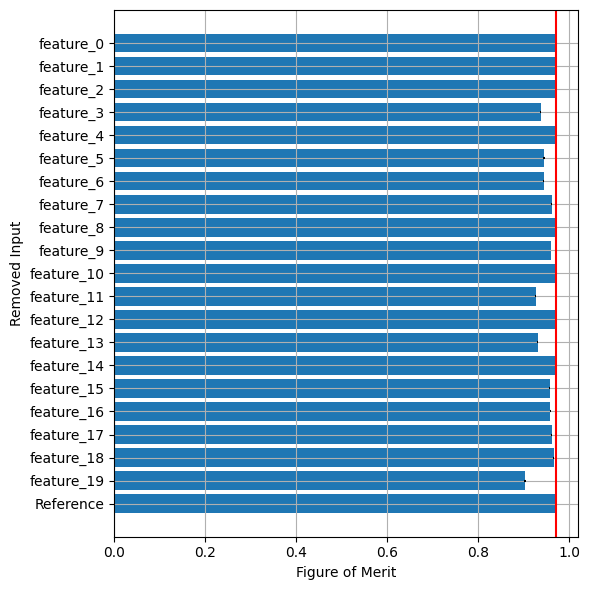

In [11]:
fig, ax = plt.subplots(figsize=(6, 6)) 
    
data = df_data.copy()

df_relevance = pd.read_csv(os.path.join(model_path,'%s_%s_relevance.csv'%(df_config['hash_id'][train_id], model_type)),index_col=0)

y = np.arange(df_relevance.shape[0])
x = df_relevance.mean(axis=1).values
x_err = df_relevance.std(axis=1).values

ax.barh(y, x, xerr=x_err, align='center')

ax.set_yticks(y, labels=df_relevance.index.values)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Figure of Merit')
ax.set_ylabel('Removed Input')
plt.axvline(x=np.mean(df_relevance.loc['Reference']), color='r', linestyle='-')
plt.tight_layout()

plt.grid()
plt.show()